In [1]:
import os,sys,shutil
import glob
import numpy as np
import matplotlib.pyplot as plt
import cv2 # opencv 4.5.0 ; opencv-python 4.7.0.72
import easyocr
from PIL import Image

In [2]:
# Specify language to identify from images
reader = easyocr.Reader(['en','nl'], gpu = False)

Using CPU. Note: This module is much faster with a GPU.


In [3]:
# Load images
images = [cv2.imread(file) for file in glob.glob("Data/StreetSwipe/images_classified/*/*.jpg")]
images = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in images] # correct the color channel
print(f"Total number of images: {len(images)}")

Total number of images: 2441


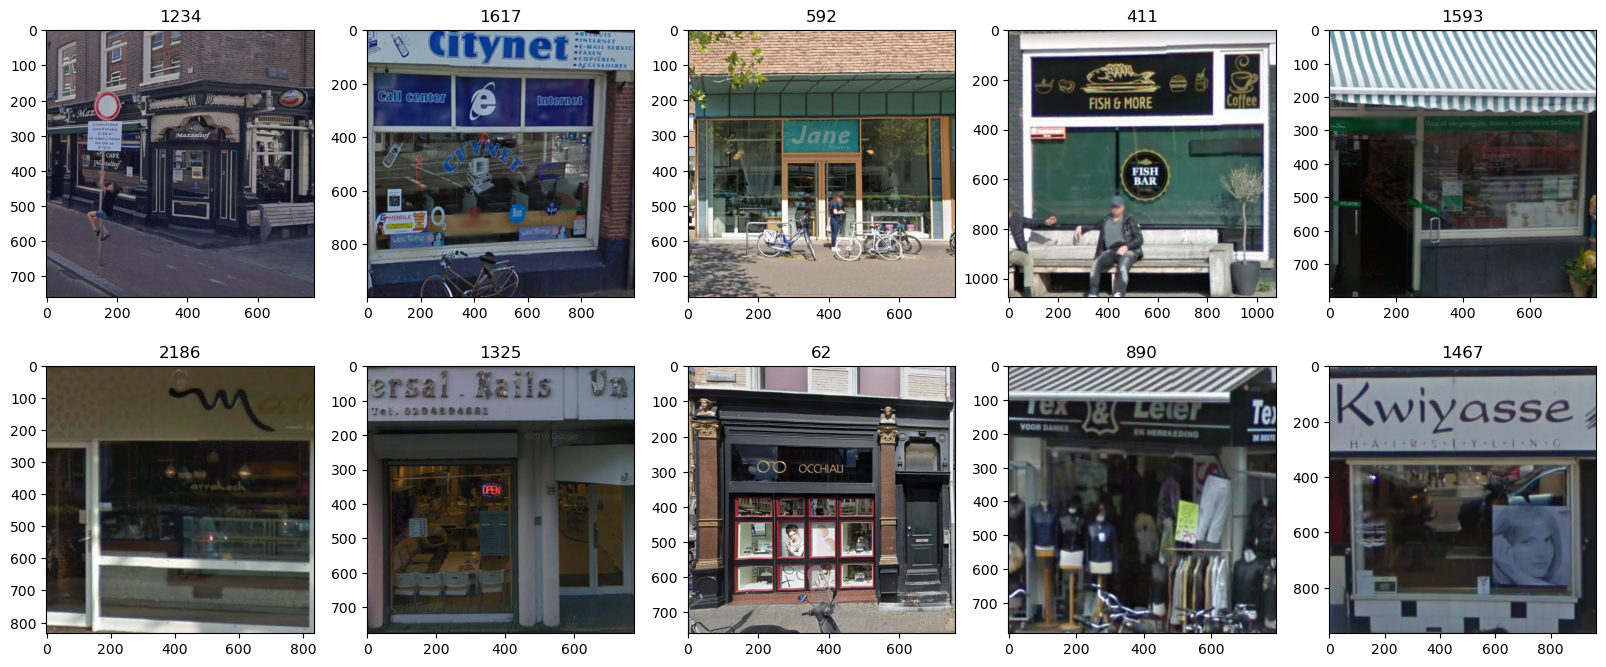

In [358]:
# Sample image
subset = np.random.randint(2441, size=(10))
test_imgs = [images[i] for i in subset]

fig = plt.figure(figsize=(20,8))
rows, cols = 2, 5

for i in range(0, cols*rows):
  fig.add_subplot(rows, cols, i+1)
  plt.imshow(test_imgs[i])
  plt.title(subset[i])
plt.show()

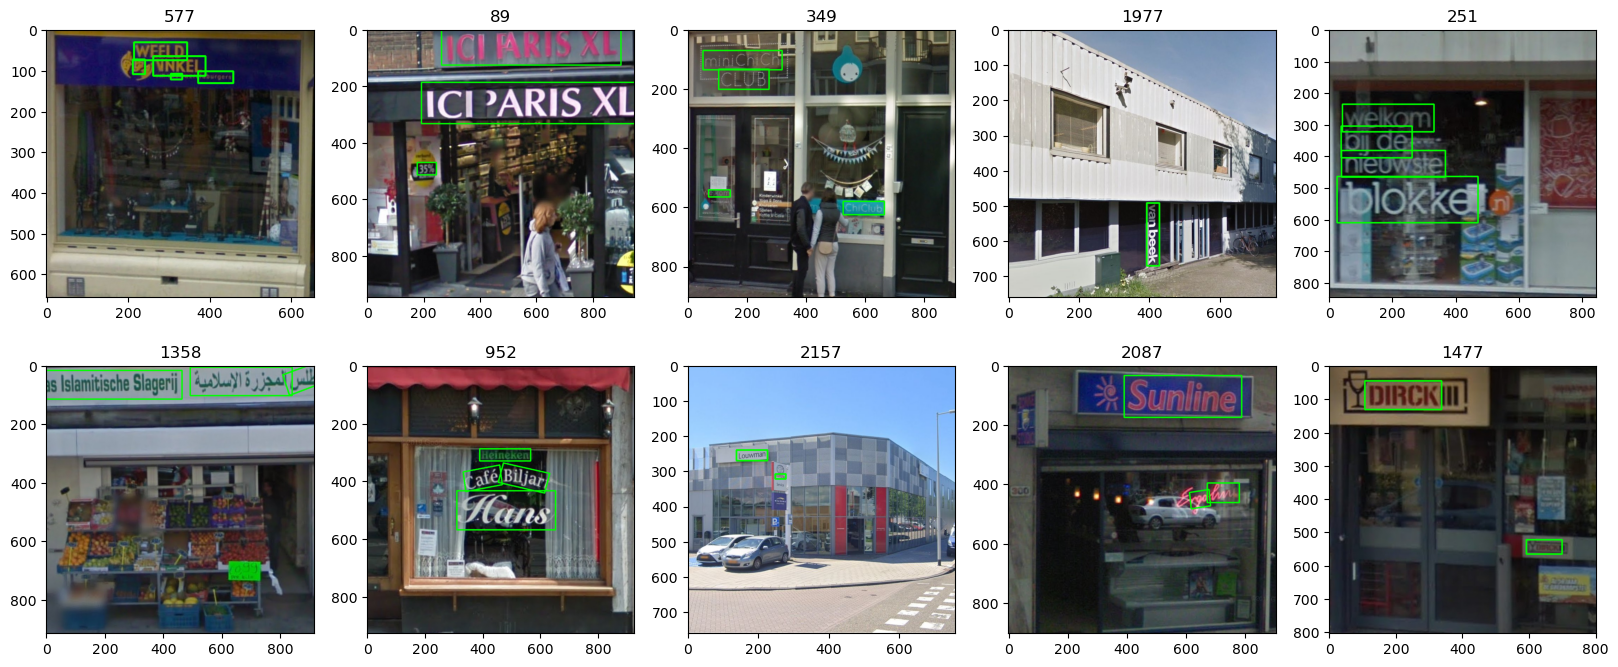

In [39]:
fig = plt.figure(figsize=(20,8))
rows, cols = 2, 5

for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)

    result = reader.detect(test_imgs[i])
    result_vis = test_imgs[i]
    spacer = 100

    for box in result[0][0]: 
        top_left = (box[0], box[2])
        bottom_right = (box[1], box[3])
        result_vis = cv2.rectangle(result_vis, top_left, bottom_right, (0,255,0), 3)
        spacer+=15

    for box in result[1][0]: 
        points = np.array(box, dtype=np.int32)
        result_vis = cv2.polylines(result_vis, [points], isClosed=True, color=(0,255,0), thickness=3)
        spacer+=15

    plt.imshow(result_vis)
    plt.title(subset[i])
plt.show()

## Detect & crop

In [6]:
# make folders for cropped-out texts
# class_names = ['gentrified','non-gentrified']
# new_folder = 'Data/StreetSwipe/images_cropped'

# for name in class_names:
#     os.makedirs(os.path.join(new_folder, name))

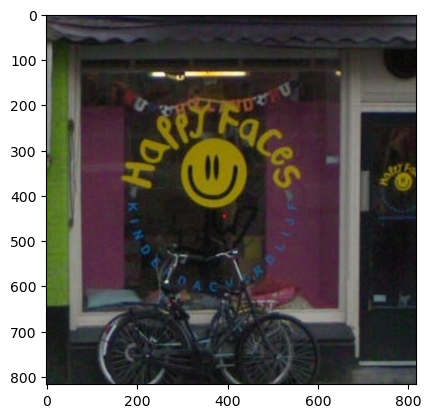

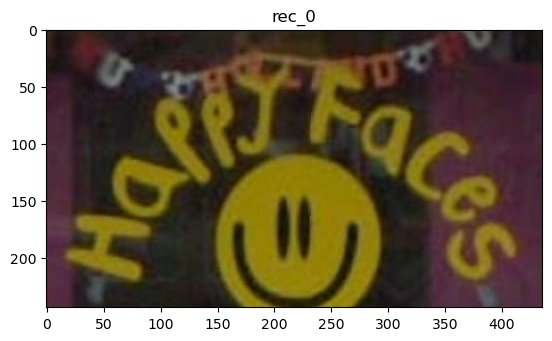

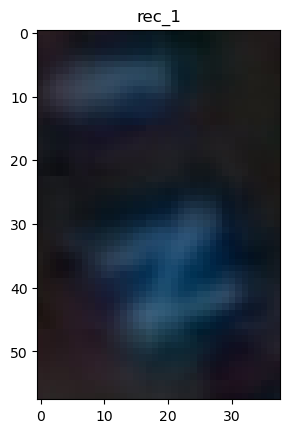

In [57]:
# empty examples: 250, 256
# rotated/non-horizontal text examples: 163, 659, 1800, 952, 1721, 1655, 912, 257, 2334

# img = cv2.imread("Data/StreetSwipe/images_classified/gentrified/20.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = images[2334]
plt.imshow(img)
plt.show()

result = reader.detect(img)
# result

if not any([result[0][0], result[1][0]]):
    print("no text")
else:
    # Crop text regions
    for i, box in enumerate(result[0][0]):
        tl = (max(0,box[0]), max(0,box[2]))
        br = (max(0,box[1]), max(0,box[3]))
        cropped_rec = img[tl[1]:br[1], tl[0]:br[0]]
    
        plt.imshow(cropped_rec)
        plt.title(f"rec_{i}")
        plt.show()

    for i, box in enumerate(result[1][0]):
        # (1) Downside: Using min and max x and y coords, yields larger bounding boxes than the ones detected & without rotation
                # Ok most of the time, but ~30% runs into ValueError bc empty array and cannot output
        # x = [] ; y = []
        # for point in box:
        #     x.append(int(point[0]))
        #     y.append(int(point[1]))
        # tl_x = min(x); tl_y = min(y)
        # br_x = max(x); br_y = max(y)
        # cropped_poly = img[tl_y:br_y, tl_x:br_x]

        # (2) Downside: Output has unexpected 90º rotations for non-horizontal texts, inherently lowers accuracy of text recognition later on
                # But can handle extremely curved text (e.g. 912), doesnt run into any error
        # source: https://jdhao.github.io/2019/02/23/crop_rotated_rectangle_opencv/
        rect = cv2.minAreaRect(np.array(box, dtype=np.int32))
        width = int(rect[1][0])
        height = int(rect[1][1])
        bound = cv2.boxPoints(rect) ; bound = np.int0(bound) # the order of the box points: lowest point --> clockwise
        src_pts = bound.astype("float32")

        # need to specify different dst_pts for the right quadrant of rect[2], still kinda morphed
        if width > height:
            dst_pts = np.array([[0, height-1],
                                [0, 0],
                                [width-1, 0],
                                [width-1, height-1]],
                                dtype="float32")
            perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
            cropped_poly = cv2.warpPerspective(img, perspective_matrix, (width, height))
        else:
            dst_pts = np.array([[0, 0],
                                [height-1, 0],
                                [height-1, width-1],
                                [0, width-1]],
                                dtype="float32")
            
            perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
            cropped_poly = cv2.warpPerspective(img, perspective_matrix, (height, width))

        plt.imshow(cropped_poly)
        plt.title(f"poly_{i}, {rect[2]}, ({width} x {height}), Bound: {bound}")
        plt.show()

        # print(type(rect[2]))


In [14]:
paths = glob.glob("Data/StreetSwipe/images_classified/*/*.jpg")
pil_img = Image.open(paths[1721])
pil_img.crop(())

ValueError: Coordinate 'lower' is less than 'upper'

In [377]:
def extract_text(origin, destination):
    """
    :origin: Folder containing images
    :destination: Folder to contain cropped-out text instances
    """
    no_text = 0
    num_file = 0
    instances = 0
    for file in glob.glob(os.path.join(origin,'*.jpg')):
        num_file += 1
        filename = os.path.split(file)[1] # {name}.jpg
        dir = os.path.join(destination, filename)

        # Read img
        img = cv2.imread(file)
        
        # Detect texts
        result = reader.detect(img, add_margin=0)

        # Crop & save text regions
        if not any([result[0][0], result[1][0]]): # if no text detected
            no_text += 1
        else:
            os.makedirs(dir) # make folder for image with text
            
            for i, box in enumerate(result[0][0]):
                instances += 1
                tl = (max(0,box[0]), max(0,box[2]))
                br = (max(0,box[1]), max(0,box[3]))
                cropped_rec = img[tl[1]:br[1], tl[0]:br[0]]
                
                des_path = os.path.join(dir, f'rec-{i}.jpg')
                if cropped_rec is not None:
                    cv2.imwrite(des_path, cropped_rec)
                else:
                    pass

            for i, box in enumerate(result[1][0]):
                instances += 1
                rect = cv2.minAreaRect(np.array(box, dtype=np.int32))
                
                width = int(rect[1][0])
                height = int(rect[1][1])

                bound = cv2.boxPoints(rect) ; bound = np.int0(bound)
                src_pts = bound.astype("float32")

                if width > height:
                    dst_pts = np.array([[0, height-1],
                                        [0, 0],
                                        [width-1, 0],
                                        [width-1, height-1]],
                                        dtype="float32")
                    perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
                    cropped_poly = cv2.warpPerspective(img, perspective_matrix, (width, height))
                else:
                    dst_pts = np.array([[0, 0],
                                        [height-1, 0],
                                        [height-1, width-1],
                                        [0, width-1]],
                                        dtype="float32")
                    
                    perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
                    cropped_poly = cv2.warpPerspective(img, perspective_matrix, (height, width))
                
                des_path = os.path.join(dir, f'poly-{i}.jpg')
                if cropped_poly is not None:
                    cv2.imwrite(des_path, cropped_poly)
                else:
                    pass
    print(f"Number of text instances: {instances}")
    print(f"Number of images without text: {no_text} ({(100 * no_text/num_file):.2f}%)")

### Gentrified

In [378]:
origin_gen = 'Data/StreetSwipe/images_classified/gentrified/'
destination_gen = 'Data/StreetSwipe/images_cropped/gentrified/'
extract_text(origin_gen, destination_gen)

KeyboardInterrupt: 

### Non-gentrified

In [ ]:
origin_nongen = 'Data/StreetSwipe/images_classified/non-gentrified/'
destination_nongen = 'Data/StreetSwipe/images_cropped/non-gentrified/'
extract_text(origin_nongen, destination_nongen)

# Panoramic

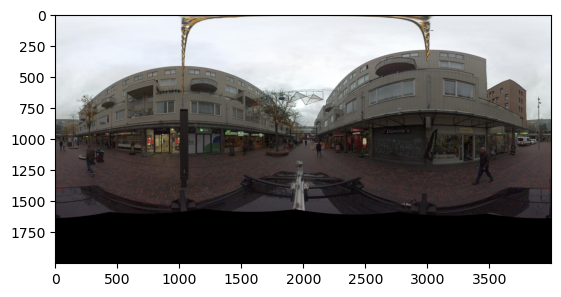

In [64]:
# "Data/Panoramic/Gaasperdam_Zuid/lon_497616383822621_lat_5229556579255464_radius_1/20221230TMX7316010203-002902pano_0000_000005_4.97615591724844_52.2955661474127.jpg"
# path = "Data/Panoramic/Amsterdamse_Poort/lon_495019758285825_lat_5231325498546227_radius_1/20221230TMX7316010203-002903pano_0000_000117_4.95020623743955_52.31325674521.jpg"
path = "Data/Panoramic/Amsterdamse_Poort/lon_495045671934885_lat_5231334477148792_radius_1/20221230TMX7316010203-002903pano_0000_000155_4.95046420342561_52.3133490660498.jpg"
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()


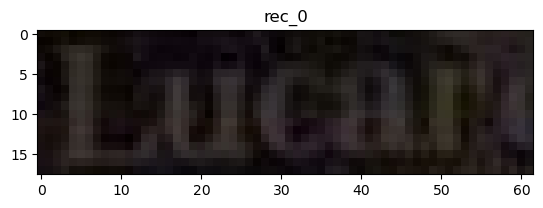

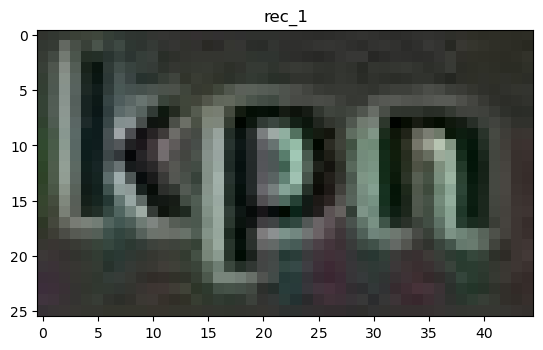

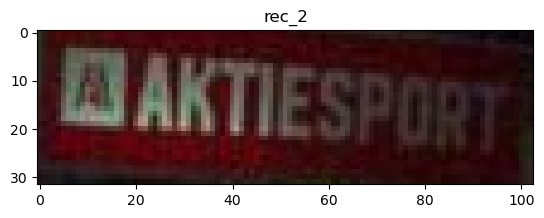

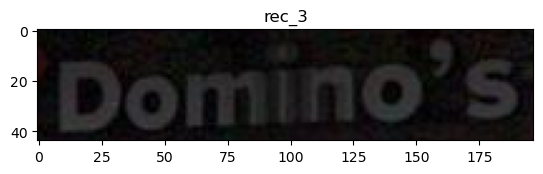

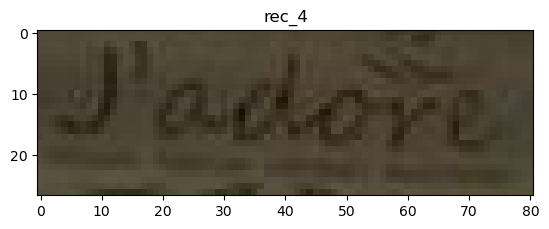

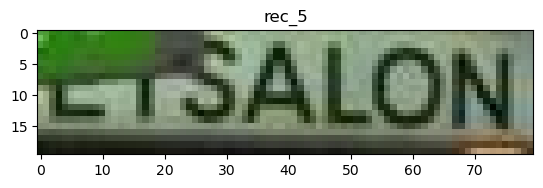

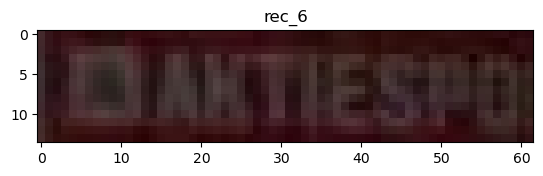

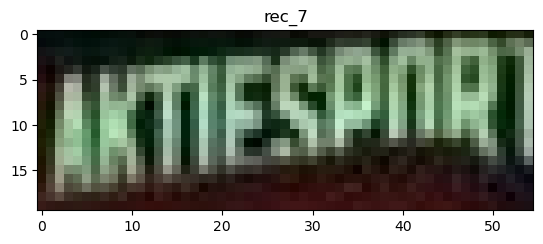

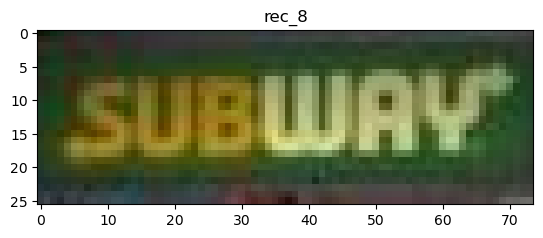

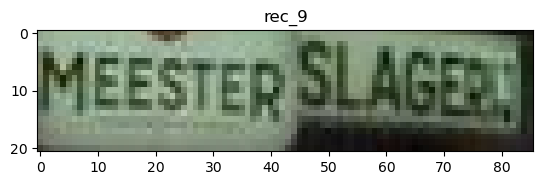

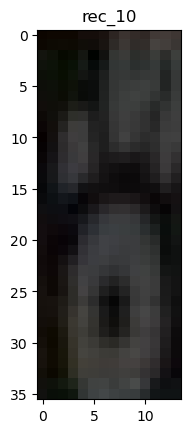

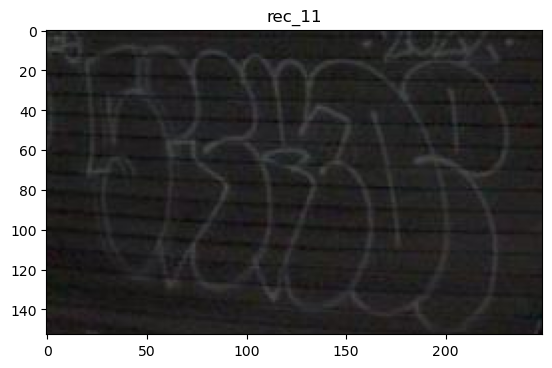

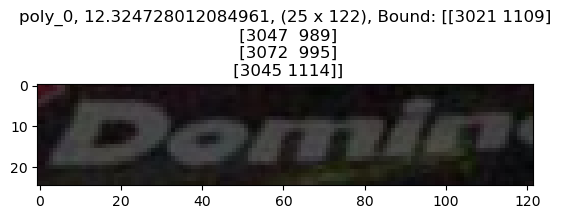

In [65]:
result = reader.detect(img)
# result

if not any([result[0][0], result[1][0]]):
    print("no text")
else:
    # Crop text regions
    for i, box in enumerate(result[0][0]):
        tl = (max(0,box[0]), max(0,box[2]))
        br = (max(0,box[1]), max(0,box[3]))
        cropped_rec = img[tl[1]:br[1], tl[0]:br[0]]
    
        plt.imshow(cropped_rec)
        plt.title(f"rec_{i}")
        plt.show()

    for i, box in enumerate(result[1][0]):
        rect = cv2.minAreaRect(np.array(box, dtype=np.int32))
        width = int(rect[1][0])
        height = int(rect[1][1])
        bound = cv2.boxPoints(rect) ; bound = np.int0(bound) # the order of the box points: lowest point --> clockwise
        src_pts = bound.astype("float32")

        if width > height:
            dst_pts = np.array([[0, height-1],
                                [0, 0],
                                [width-1, 0],
                                [width-1, height-1]],
                                dtype="float32")
            perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
            cropped_poly = cv2.warpPerspective(img, perspective_matrix, (width, height))
        else:
            dst_pts = np.array([[0, 0],
                                [height-1, 0],
                                [height-1, width-1],
                                [0, width-1]],
                                dtype="float32")
            
            perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
            cropped_poly = cv2.warpPerspective(img, perspective_matrix, (height, width))

        plt.imshow(cropped_poly)
        plt.title(f"poly_{i}, {rect[2]}, ({width} x {height}), Bound: {bound}")
        plt.show()


In [ ]:
# modified for panoramic data, to keep tree structure
def extract_text_p(origin, destination):
    """
    :origin: Folder containing images, grouped by gentrified/non-gentrified
    :destination: Folder to contain cropped-out text instances, grouped by gentrified/non-gentrified
    """
    no_text = 0
    num_file = 0
    instances = 0
    file = os.path.join(destination, "img-with-text.txt")
    open(file, 'a').close()

    # neighborhood per class (gentrified/non-gentrified)
    nbhd_dir = glob.glob(os.path.join(origin,"*")) # AmsPano/images_classified/{(non)gentrified}/{* = nbhd}
    for nbhd_folder in nbhd_dir:
        nbhd_name = os.path.split(nbhd_folder)[1]
        des_nbhd_folder = os.path.join(destination, nbhd_name) # AmsPano/images_cropped/{(non)gentrified}/{nbhd}
        os.makedirs(des_nbhd_folder) # Make corresponding folder for nbhd in new directory

        # location per nbhd (lon-lat)
        location_dir = glob.glob(os.path.join(nbhd_folder, "*"))
        for location in location_dir:
            location_name = os.path.split(location)[1]
            des_location_folder = os.path.join(des_nbhd_folder, location_name) # AmsPano/images_cropped/{(non)gentrified}/{* = nbhd}
            
            # img per location
            img_dir = glob.glob(os.path.join(location, "*.jpg"))
            for image in img_dir:
                num_file += 1
                img_name = os.path.split(image)[1]

                # Read img
                img = cv2.imread(image)
                # Detect texts
                result = reader.detect(img, add_margin=0)

                # Crop & save text regions
                if not any([result[0][0], result[1][0]]): # If no text detected
                    no_text += 1
                else: # If text detected
                    with open(str(file), "a") as f: 
                        f.write(img_name + '\n') # Record img name
                    os.makedirs(des_location_folder) # Make corresponding folder for img location in new directory
                
                    for i, box in enumerate(result[0][0]):
                        instances += 1
                        tl = (max(0,box[0]), max(0,box[2]))
                        br = (max(0,box[1]), max(0,box[3]))
                        cropped_rec = img[tl[1]:br[1], tl[0]:br[0]]
                        
                        des_path = os.path.join(des_location_folder, f'rec-{i}.jpg')
                        if cropped_rec is not None:
                            cv2.imwrite(des_path, cropped_rec)
                        else:
                            pass

                    for i, box in enumerate(result[1][0]):
                        instances += 1
                        rect = cv2.minAreaRect(np.array(box, dtype=np.int32))

                        width = int(rect[1][0])
                        height = int(rect[1][1])

                        bound = cv2.boxPoints(rect) ; bound = np.int0(bound)
                        
                        src_pts = bound.astype("float32")

                        if width > height:
                            dst_pts = np.array([[0, height-1],
                                                [0, 0],
                                                [width-1, 0],
                                                [width-1, height-1]],
                                                dtype="float32")
                            perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
                            cropped_poly = cv2.warpPerspective(img, perspective_matrix, (width, height))
                        else:
                            dst_pts = np.array([[0, 0],
                                                [height-1, 0],
                                                [height-1, width-1],
                                                [0, width-1]],
                                                dtype="float32")
                            
                            perspective_matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
                            cropped_poly = cv2.warpPerspective(img, perspective_matrix, (height, width))
                        
                        des_path = os.path.join(des_location_folder, f'poly-{i}.jpg')
                        if cropped_poly is not None:
                            cv2.imwrite(des_path, cropped_poly)
                        else:
                            pass
    print(f"Number of text instances: {instances}")
    print(f"Number of images without text: {no_text} ({(100 * no_text/num_file):.2f}%)")